# Time Series Forecasting with XGBoost



We will be using an hourly energy consumption dataset from Kaggle at https://www.kaggle.com/datasets/robikscube/hourly-energy-consumption. The dataset captures energy consumption for different regions in a portion of the country. These values are at an hourly basis for over ten years. The data comes from PJM's website and are in megawatts (MW).

The regions have changed over the years so data may only appear for certain dates per region.


In [2]:
import pandas as pd 
import numpy as np  
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')    # This is a popular style choice for matplotlib

## Step 0. Data Preprocessing

In [3]:
df = pd.read_csv('PJME_hourly.csv')
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index) #The dataframe index is an object, we need to convert it to a datetime object.

In [4]:
df.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


In [5]:
df.tail()

,PJME_MW
Datetime,
2018-01-01 20:00:00,44284.0
2018-01-01 21:00:00,43751.0
2018-01-01 22:00:00,42402.0
2018-01-01 23:00:00,40164.0
2018-01-02 00:00:00,38608.0


We see from the head and tail functions that the data is in hourly format, from 2002 to 2018.

In [6]:
df.describe()

,PJME_MW
count,145366.000000
mean,32080.222831
std,6464.012166
min,14544.000000
25%,27573.000000
50%,31421.000000
75%,35650.000000
max,62009.000000


Lets plot this to visualize what we are working with.

<Axes: title={'center': 'PJME Power Consumption (in MW)'}, xlabel='Datetime'>

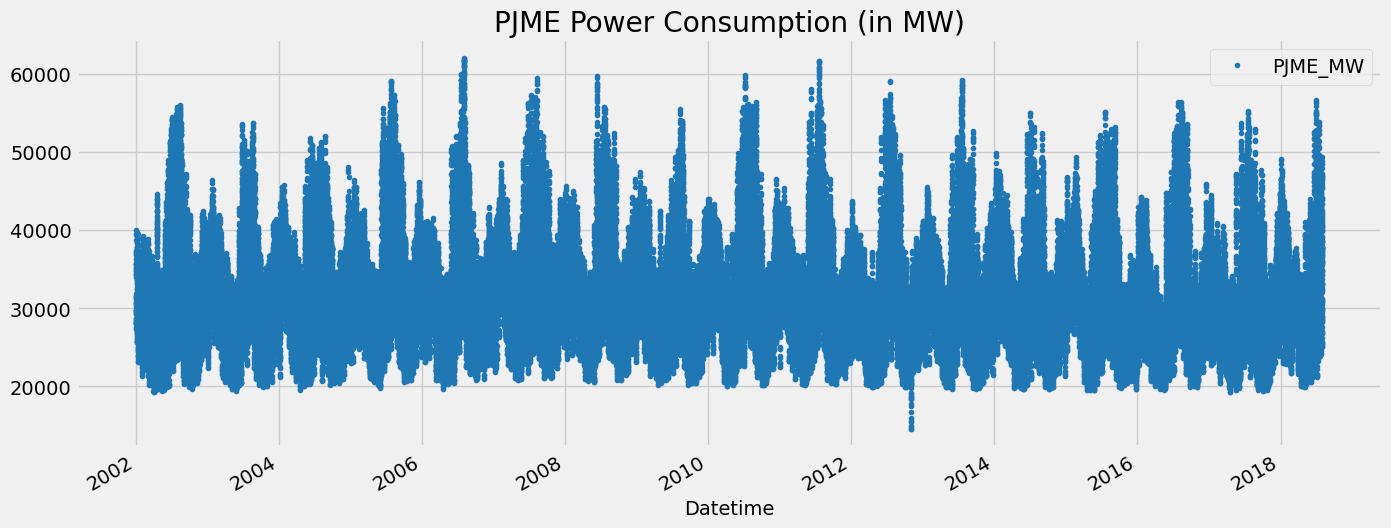

In [7]:
df.plot(style='.',
        figsize=(15, 6),
        color=color_pal[0], 
        title="PJME Power Consumption (in MW)")

Looking at the graph above, there appears to be an area around 2012/2013 where the data appears to be really low. There good be data quality issues. Perhaps there were blackouts during that time or issues with the sensors.  ML models will learn from these outliers so we need to investigate further. Let’s zoom in on that area to see what’s going on.

#### Outlier Analysis and Removal

<Axes: ylabel='Frequency'>

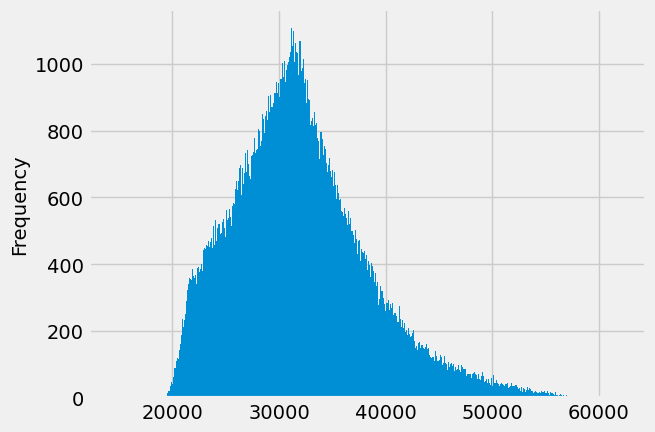

In [8]:
df['PJME_MW'].plot.hist(bins=500)

Most of the values fall between 20k to about 50k.  There seems to be right skew in the data.  However, I am more interested in the values that are less than 20k.  I will plot a histogram of the values less than 20k.

array([<Axes: xlabel='Datetime'>], dtype=object)

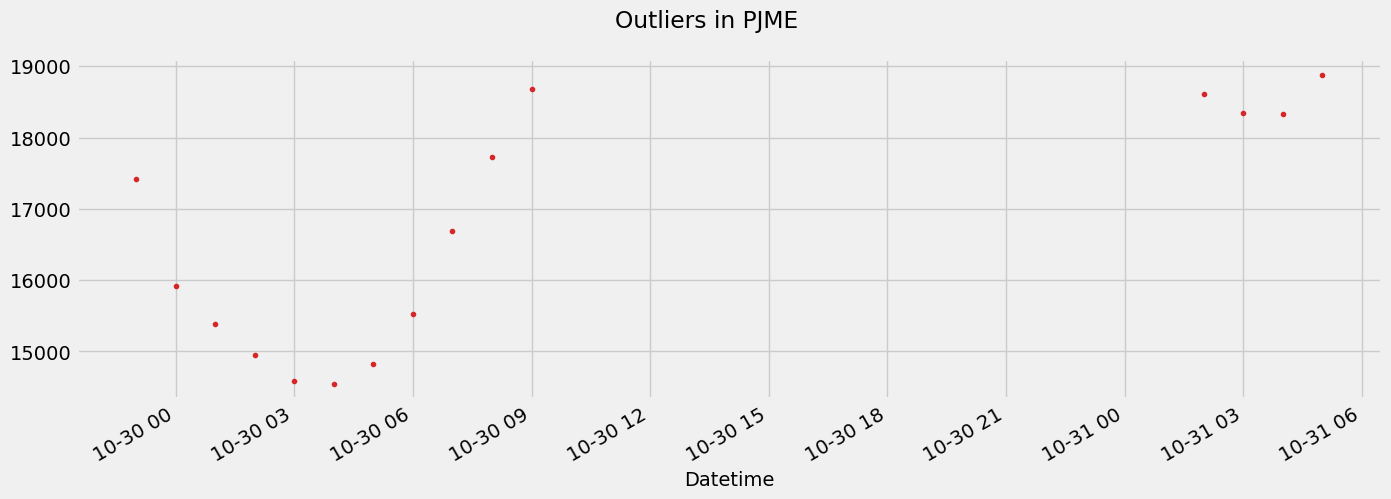

In [18]:
df.query('PJME_MW < 19000')['PJME_MW'] \
    .plot(subplots=True, figsize=(15, 5), 
          color=color_pal[3],
          title='Outliers in PJME',
            style='.')

We can see that the values do get below 20000 sometimes but there is a particular area where the values fall well below 20000. There are some outliers that do not appear to be legitimate values. Lets zoom in further by setting the threshold from 20k to 19k.

With the new threshold, we can see the values that dip really low that we want to remove from our training and validation sets.

In [19]:
df = df.query('PJME_MW > 19000').copy() #copy over the filtered out outliers

## Step 2.  Train/Test Split

In [20]:
df.shape

(145351, 1)

We are going to split the data on the date January, 2015. The reason for this is that we want to train our model on data before this date and test our model on data after this date. This is a common practice in time series modeling.            

In [22]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

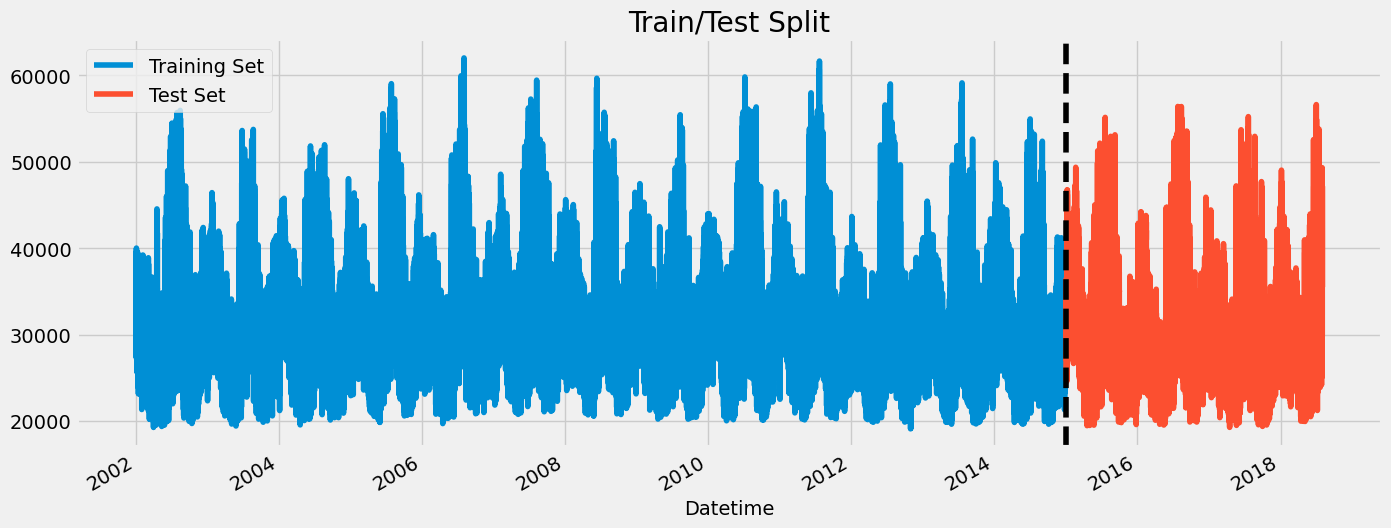

In [23]:
fig, ax = plt.subplots(figsize=(15, 6))
train.plot(ax=ax, label='train')
test.plot(ax=ax, label='test')
ax.axvline(pd.to_datetime('01/01/2015'), color='k', linestyle='--')
ax.legend(['Training Set', 'Test Set'])
ax.set_title('Train/Test Split')
plt.show()

## Time Series Cross Validation

In [25]:
tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df = df.sort_index() # if this is not sorted, the tss will not work

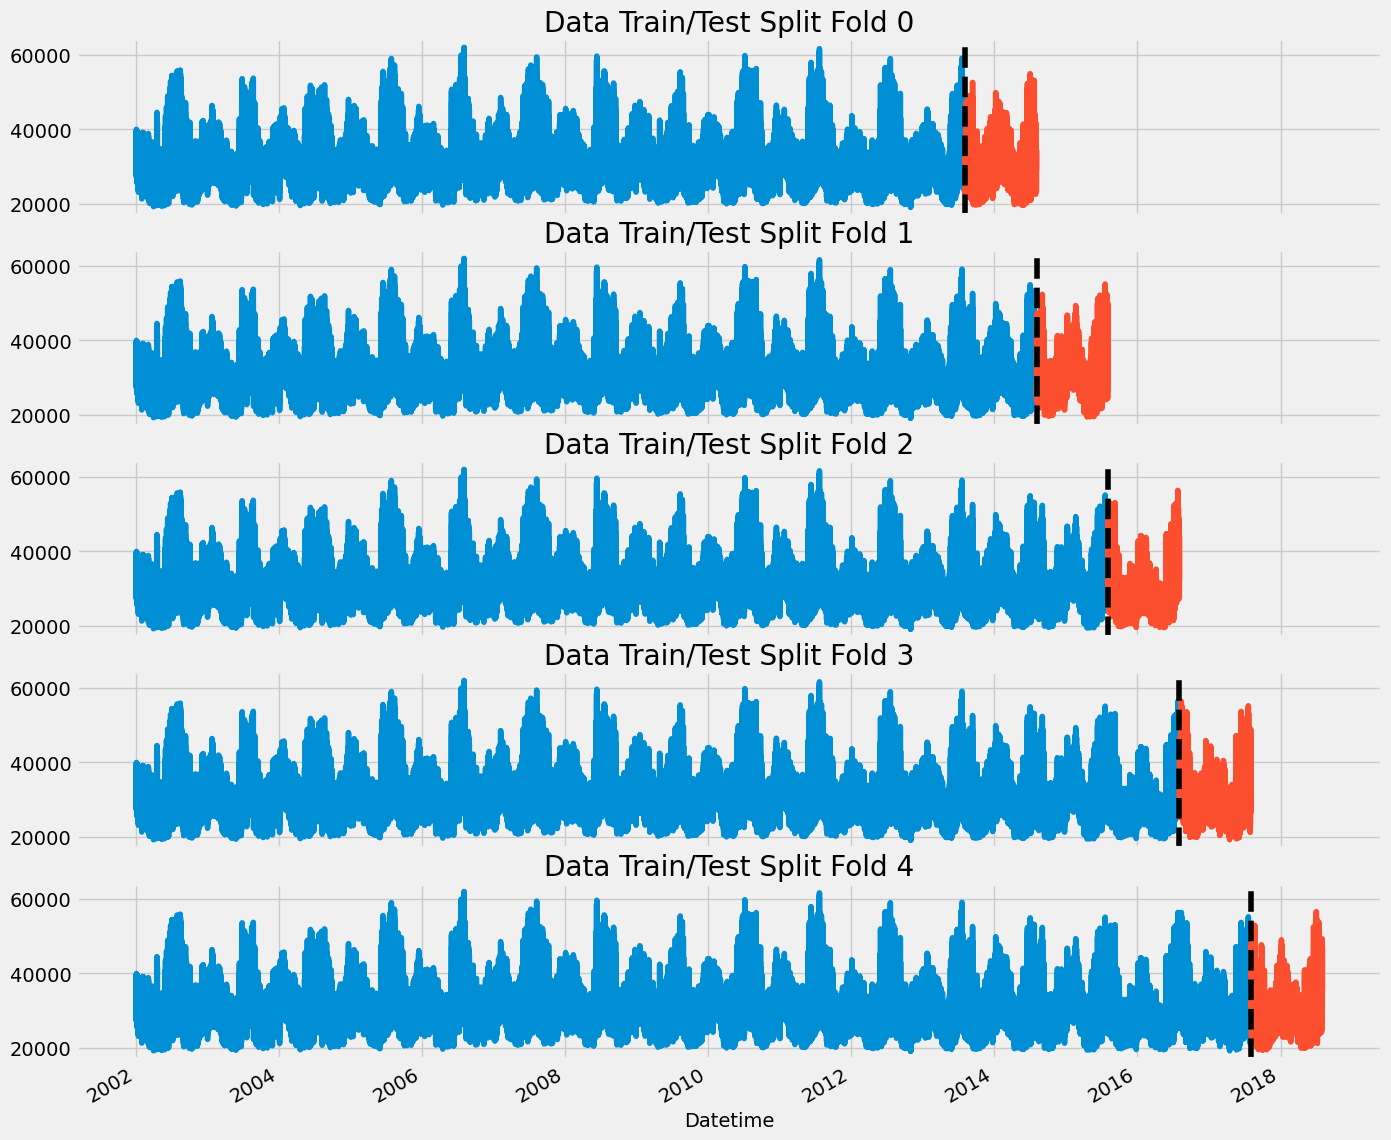

In [26]:
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train['PJME_MW'].plot(ax=axs[fold], 
                        label='Training Set',
                        title=f'Data Train/Test Split Fold {fold}')
    test['PJME_MW'].plot(ax=axs[fold],
                        label='Test Set')
    axs[fold].axvline(test.index.min(), color='k', linestyle='--')
    fold += 1
plt.show()
    

The visual makes it easier to see what is going on.  Since we have so much historical data, each fold works so that it is going back in time and then we have one year of our validation set each fold.
  
We are able to test each of the last five years independently from each other.  It is important to do it this way when we're doing cross-validation we want to make sure that we are as leak free as possible.  We don't want to have any data leakage from the training set into the validation set.  We want to make sure that we are not using any data from the future to predict the past.  We want to make sure that we are only using data from the past to predict the future.  This is why we are using the TimeSeriesSplit.  It is a very useful tool for time series data.  It is a little bit more complicated than the normal cross-validation, but it is very useful for time series data.


#### Forecasting Horizon

The forecast horizon is the length of time into the future for which forecasts are to be prepared. These generally vary from short-term forecasting horizons (less than three months) to long term (more than two years).

## Feature Engineering


We can use pandas .hour attribute to get the hour of the day for each index. We can also use other attributes to pull additional data from the index.  To make this cleaner, will create a function called features for our engineering.
   
We will add these as new columns to our dataframe.


In [27]:

def create_features(df):
    """
    Creates time series features from datetime index
    """
    df = df.copy() # We don't want to modify the original dataframe
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek # Monday=0, Sunday=6
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    return df

df = create_features(df)

## Lag Features
* What was the target (x) days in the past

We are going to create a dictionary with this which we will use for mapping these lag features onto our dataframe.
  
Now lets take the dataframe index for every day and subtract a time delta.
We use 364 and not 365 because its divisible by 7 and get exact day of the week


In [28]:

def add_lags(df):
    target_map = df['PJME_MW'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map) 
    df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map) 
    df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map) 
    return df

In [29]:
df = add_lags(df)
df.tail()

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,lag1,lag2,lag3
Datetime,,,,,,,,,,
2018-08-02 20:00:00,44057.0,20,3,3,8,2018,214,42256.0,41485.0,38804.0
2018-08-02 21:00:00,43256.0,21,3,3,8,2018,214,41210.0,40249.0,38748.0
2018-08-02 22:00:00,41552.0,22,3,3,8,2018,214,39525.0,38698.0,37330.0
2018-08-02 23:00:00,38500.0,23,3,3,8,2018,214,36490.0,35406.0,34552.0
2018-08-03 00:00:00,35486.0,0,4,3,8,2018,215,33539.0,32094.0,31695.0


#### Train Using Cross Validation

In [30]:
tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df = df.sort_index() # if this is not sorted, the tss will not work

fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    FEATURES = ['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear', 
                'lag1', 'lag2', 'lag3']
    TARGET = 'PJME_MW'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                           n_estimators=1000, 
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.1)
                    
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)
    
    y_pred = reg.predict(X_test)

    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)


[15:54:26] WARNING: c:\users\dev-admin\croot2\xgboost-split_1675461376218\work\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:29808.18338	validation_1-rmse:29056.76576
[86]	validation_0-rmse:3160.91633	validation_1-rmse:3773.27893
[15:54:31] WARNING: c:\users\dev-admin\croot2\xgboost-split_1675461376218\work\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:29753.10470	validation_1-rmse:29241.12221
[100]	validation_0-rmse:3171.30750	validation_1-rmse:3423.01676
[200]	validation_0-rmse:2979.43361	validation_1-rmse:3411.25070
[247]	validation_0-rmse:2918.93468	validation_1-rmse:3437.14614
[15:54:47] WARNING: c:\users\dev-admin\croot2\xgboost-split_1675461376218\work\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:29715.51034	validation_1-rmse:28163.63440
[83]	validation_0-rmse:3223.

In [31]:
 # We have run 5 different experiments, let's see how we did

print(f'Average RMSE: {np.mean(scores):0.4f}')
print(f'Fold Scores: {scores}')

Average RMSE: 3707.1615
Fold Scores: [3754.333560365081, 3407.8282628074835, 3482.1418609144566, 3892.514076892871, 3998.989508482909]


## Predicting the Future
* Retraining on all data
* To predict the future we need an empty dataframe for future data ranges
* Run those dates through our feature creation code + lag creation
  
In order to predict on the future, its fairly simple.  We just want to create a skeleton frame of dates that we want to predict for.

##### Retrain on all data

In [32]:
df = create_features(df)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year',
            'lag1','lag2','lag3']
TARGET = 'PJME_MW'

X_all = df[FEATURES]
y_all = df[TARGET]

reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',    
                       n_estimators=500,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)

[15:59:19] WARNING: c:\users\dev-admin\croot2\xgboost-split_1675461376218\work\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:32403.88753
[100]	validation_0-rmse:12426.44700
[200]	validation_0-rmse:5752.69704
[300]	validation_0-rmse:3970.08787
[400]	validation_0-rmse:3569.37848
[499]	validation_0-rmse:3454.55122


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

In [33]:
df.index.max()

Timestamp('2018-08-03 00:00:00')

We will use our regressor, reg, to predict  in the future. We will need to make this future dataframe.

In [38]:
# Create a dataframe with the predictions
future = pd.date_range('2018-08-03', '2019-08-01', freq='1h')
future_df = pd.DataFrame(index=future)

# Because we are using lagged features, we need to put this onto th end of our existing data so we can add the lags correctly

# before doing this, create a new column called 'isFuture' so we can filter out the future data later
future_df['isFuture'] = True
df['isFuture'] = False

#make a new dataframe that is a concatenation of the two
df_and_future = pd.concat([df, future_df])

# We need to create our features on top of this new dataframe
df_and_future = create_features(df_and_future)

# and also add our lag features
df_and_future = add_lags(df_and_future)


In [42]:
# Now that we have added our lag features, we can filter out the future data
future_w_features = df_and_future.query('isFuture == True').copy()

In [43]:
future_w_features

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,lag1,lag2,lag3,isFuture
2018-08-03 00:00:00,NaN,0,4,3,8,2018,215,33539.0,32094.0,31695.0,True
2018-08-03 01:00:00,NaN,1,4,3,8,2018,215,30781.0,29503.0,29128.0,True
2018-08-03 02:00:00,NaN,2,4,3,8,2018,215,29015.0,27712.0,27373.0,True
2018-08-03 03:00:00,NaN,3,4,3,8,2018,215,27884.0,26535.0,26233.0,True
2018-08-03 04:00:00,NaN,4,4,3,8,2018,215,27223.0,25870.0,25643.0,True
...,...,...,...,...,...,...,...,...,...,...,...
2019-07-31 20:00:00,NaN,20,2,3,7,2019,212,46912.0,39352.0,40243.0,True
2019-07-31 21:00:00,NaN,21,2,3,7,2019,212,45985.0,38699.0,39183.0,True
2019-07-31 22:00:00,NaN,22,2,3,7,2019,212,44094.0,37346.0,37759.0,True
2019-07-31 23:00:00,NaN,23,2,3,7,2019,212,40666.0,34555.0,34641.0,True


## Predict the future

In [44]:
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])

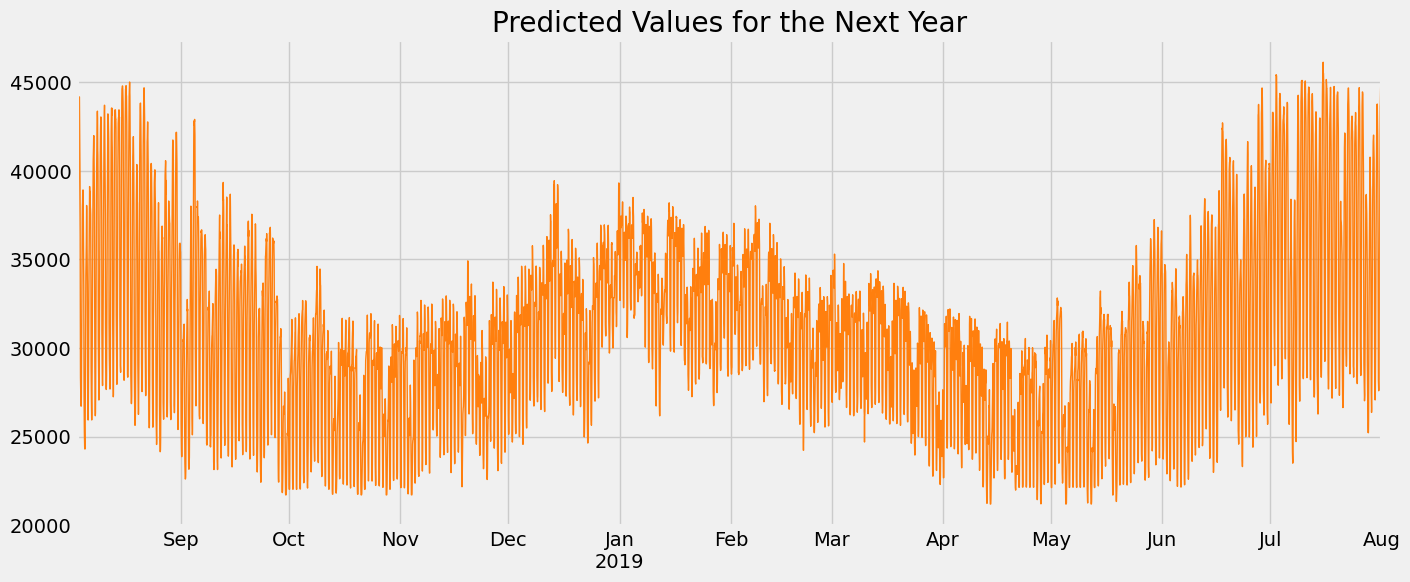

In [47]:
future_w_features['pred'].plot(figsize=(15, 6),
                               color=color_pal[1],
                               title='Predicted Values for the Next Year',
                               ms=1, lw=1)
plt.show()

## Saving Model for Later
* Saving model for reuse

In [48]:
# Save model
reg.save_model('model.json')

In [53]:
# load model and make predictions
reg_new = xgb.XGBRegressor()
reg_new.load_model('model.json')

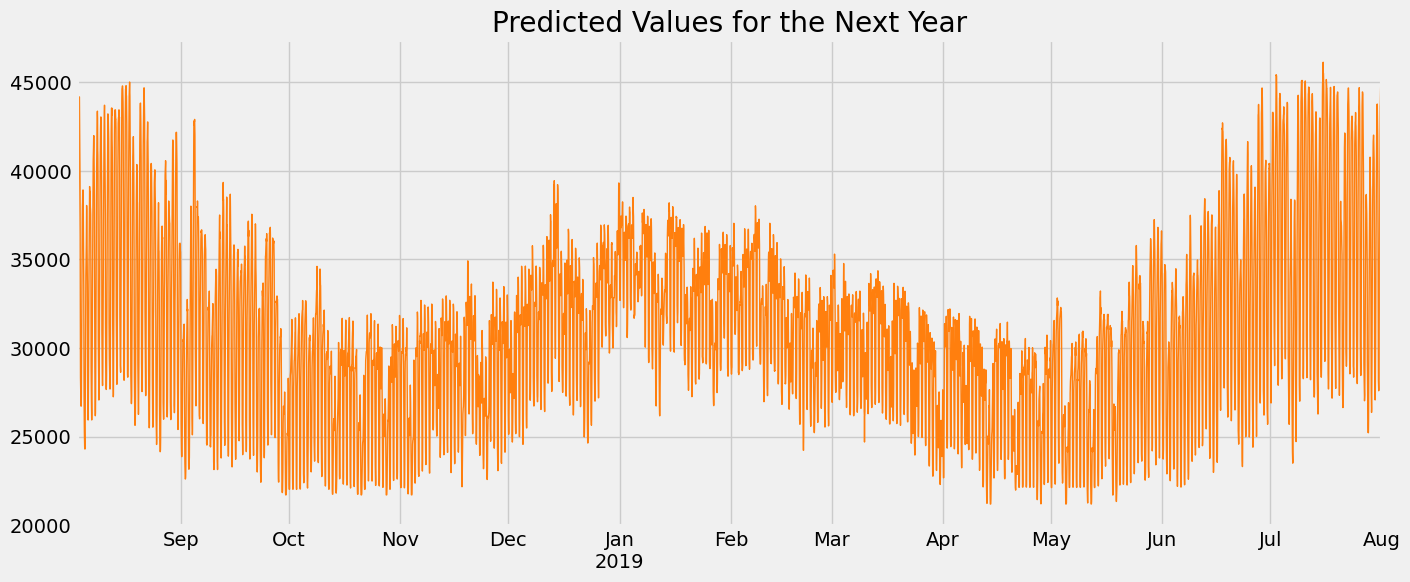

In [54]:
# make prediction using the loaded model
future_w_features['pred'] = reg_new.predict(future_w_features[FEATURES])
future_w_features['pred'].plot(figsize=(15, 6),
                               color=color_pal[1],
                               title='Predicted Values for the Next Year',
                               ms=1, lw=1)
plt.show()

The predictions with the loaded model should and do look identical to previously ran predictions.

# The End